                          LIQUID STAKING DERIVATIVE INDEX OPTIMIZATION

This project aims to optimize the weights of The Liquid Staked ETH index (LSETH) using Genetic Algorithms. The index token contains an equal-weighted basket (20%) of the 5 leading liquid staked Ether derivatives to reduce volatility and mitigate underlying protocol risk compared to holding individual tokens.

Downloading historical prices

In [1]:
import requests
import pandas as pd
from datetime import datetime

index = [
   "rocket-pool-eth",
    "wrapped-steth",
    "staked-frax-ether",
    "coinbase-wrapped-staked-eth",
    "ankreth",
    "liquid-staked-eth-index"
]

data_list = []

for name in index:
    url = f"https://api.coingecko.com/api/v3/coins/{name}/market_chart"
    parameters = {
        "vs_currency": "eth",
         "days": "150"
    }
    response = requests.get(url, params=parameters)

    if response.status_code == 200:
        data = response.json()
        prices = data["prices"]
        for price in prices:
            timestamp = price[0] / 1000  # Convert milliseconds to seconds
            price_value = price[1]
            date = pd.to_datetime(timestamp, unit='s').strftime("%Y-%m-%d")
            data_list.append([name, date, price_value])
    else:
        print(f"Error occurred while retrieving data for {name}.")

# Create a DataFrame from the collected data
df1 = pd.DataFrame(data_list, columns=["Name", "Date", "Price"])
df1 = df1.sort_values("Date")
df1.set_index("Date", inplace=True)

df1

,Name,Price
Date,,
2023-01-16,rocket-pool-eth,1.064756
2023-01-16,ankreth,1.004351
2023-01-16,coinbase-wrapped-staked-eth,0.987675
2023-01-16,staked-frax-ether,1.015964
2023-01-16,wrapped-steth,1.096141
...,...,...
2023-06-14,coinbase-wrapped-staked-eth,1.037442
2023-06-14,rocket-pool-eth,1.075056
2023-06-14,rocket-pool-eth,1.074492


In [2]:
pivot_df1 = df1.pivot_table(index=df1.index, columns='Name', values='Price')
pivot_df1

Name,ankreth,coinbase-wrapped-staked-eth,liquid-staked-eth-index,rocket-pool-eth,staked-frax-ether,wrapped-steth
Date,,,,,,
2023-01-16,1.004351,0.987675,NaN,1.064756,1.015964,1.096141
2023-01-17,0.973837,0.990344,NaN,1.069676,1.013531,1.099075
2023-01-18,1.030344,0.994129,NaN,1.064854,1.012423,1.098706
2023-01-19,1.028569,0.997020,NaN,1.066325,1.010846,1.099061
2023-01-20,1.028710,0.995118,NaN,1.069551,1.015850,1.101371
...,...,...,...,...,...,...
2023-06-10,1.112879,1.037661,NaN,1.074277,1.042319,1.126968
2023-06-11,1.113508,1.036198,NaN,1.073126,1.042534,1.126674
2023-06-12,1.119722,1.036497,NaN,1.073363,1.042480,1.127529


Imputing missing values

In [3]:
from sklearn.impute import KNNImputer

# Define the KNN imputer
imputer = KNNImputer(n_neighbors=5)

# Perform KNN imputation
imputed_data = imputer.fit_transform(pivot_df1)

# Convert the imputed data back to a DataFrame
pivot_df1 = pd.DataFrame(imputed_data, index=pivot_df1.index, columns=pivot_df1.columns)
pivot_df1

Name,ankreth,coinbase-wrapped-staked-eth,liquid-staked-eth-index,rocket-pool-eth,staked-frax-ether,wrapped-steth
Date,,,,,,
2023-01-16,1.004351,0.987675,1.013843,1.064756,1.015964,1.096141
2023-01-17,0.973837,0.990344,1.015541,1.069676,1.013531,1.099075
2023-01-18,1.030344,0.994129,1.011608,1.064854,1.012423,1.098706
2023-01-19,1.028569,0.997020,1.011608,1.066325,1.010846,1.099061
2023-01-20,1.028710,0.995118,1.011608,1.069551,1.015850,1.101371
...,...,...,...,...,...,...
2023-06-10,1.112879,1.037661,0.995616,1.074277,1.042319,1.126968
2023-06-11,1.113508,1.036198,0.995802,1.073126,1.042534,1.126674
2023-06-12,1.119722,1.036497,0.997033,1.073363,1.042480,1.127529


Plotting Returns and Volatilities

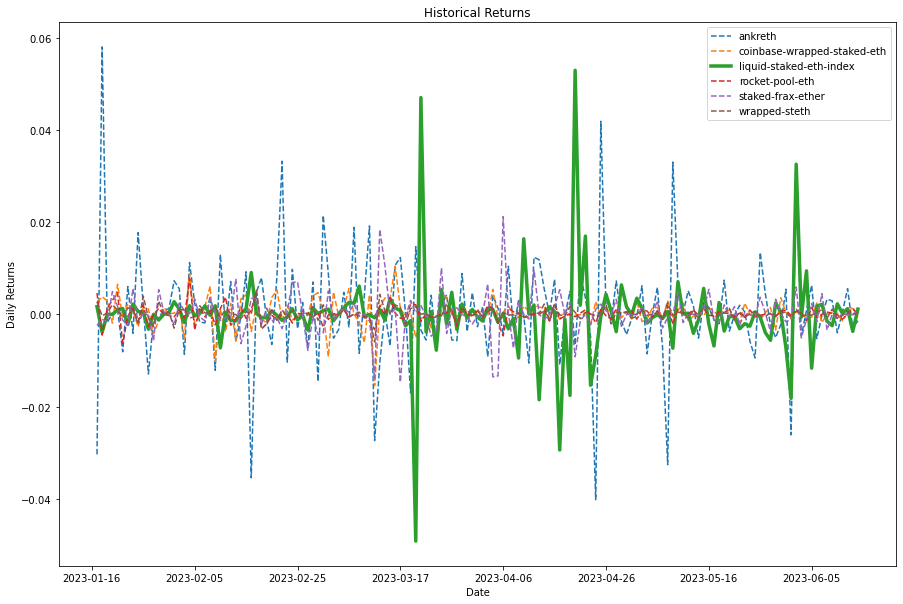

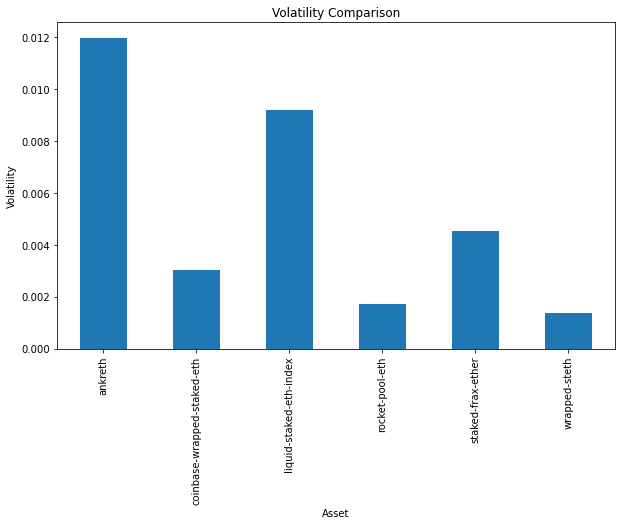

In [4]:
import matplotlib.pyplot as plt

# Calculate daily returns
returns = pivot_df1.pct_change()

# Calculate volatility (standard deviation of returns)
volatility = returns.std()

# Plotting the returns
plt.figure(figsize=(15, 10))
for col in returns.columns:
    if col == 'liquid-staked-eth-index':
        returns[col].plot(ax=plt.gca(), label=col, linewidth=3.5)
    else:
        returns[col].plot(ax=plt.gca(), linestyle='--', label=col)
plt.ylabel('Daily Returns')
plt.title('Historical Returns')
plt.legend()
plt.show()

# Plotting the volatility
plt.figure(figsize=(10, 6))
volatility.plot(kind='bar')
plt.xlabel('Asset')
plt.ylabel('Volatility')
plt.title('Volatility Comparison')
plt.show()

We can actually see that LSETH index shows a bigger volatilty compared to most liquid staked derivatives...

In [5]:
# Create a new DataFrame containing LSETH 
df_index = pivot_df1[['liquid-staked-eth-index']]

# Create a new DataFrame containing index components
pivot_df2 = pivot_df1.drop(columns=['liquid-staked-eth-index'])

In [6]:
df_index

Name,liquid-staked-eth-index
Date,
2023-01-16,1.013843
2023-01-17,1.015541
2023-01-18,1.011608
2023-01-19,1.011608
2023-01-20,1.011608
...,...
2023-06-10,0.995616
2023-06-11,0.995802
2023-06-12,0.997033


In [7]:
pivot_df2

Name,ankreth,coinbase-wrapped-staked-eth,rocket-pool-eth,staked-frax-ether,wrapped-steth
Date,,,,,
2023-01-16,1.004351,0.987675,1.064756,1.015964,1.096141
2023-01-17,0.973837,0.990344,1.069676,1.013531,1.099075
2023-01-18,1.030344,0.994129,1.064854,1.012423,1.098706
2023-01-19,1.028569,0.997020,1.066325,1.010846,1.099061
2023-01-20,1.028710,0.995118,1.069551,1.015850,1.101371
...,...,...,...,...,...
2023-06-10,1.112879,1.037661,1.074277,1.042319,1.126968
2023-06-11,1.113508,1.036198,1.073126,1.042534,1.126674
2023-06-12,1.119722,1.036497,1.073363,1.042480,1.127529


Running the Optimization 

In [8]:
import random
import numpy as np
from deap import base, creator, tools, algorithms

# Define the token names
tokens = pivot_df2.columns.tolist()

# Calculate the variances
variance = pivot_df2.var()

# Calculate the covariances
covariance_matrix = pivot_df2.cov()

# Define the Problem - Objective Function
def calculate_portfolio_risk(weights, covariance_matrix):
    portfolio_variance = np.dot(weights, np.dot(covariance_matrix, weights))
    return portfolio_variance

def normalize_weights(weights):
    sum_weights = sum(weights)
    normalized_weights = [(w / sum_weights) for w in weights]
    bounded_weights = [max(0, min(w, 1)) for w in normalized_weights]
    return bounded_weights

def evaluate(individual):
    # Calculate portfolio risk (variance) based on weights
    weights = normalize_weights(individual)
    risk = calculate_portfolio_risk(weights, covariance_matrix)
    return -risk,  # Negative sign to minimize the risk

# Define the components and number of tokens
components = tokens
num_currencies = len(components)

population_size = 100
num_generations = 50

# Define the Individual Representation
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Define the Genetic Operators
toolbox = base.Toolbox()
toolbox.register("attribute", random.uniform, 0, 1)  # Range set to (0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attribute, n=num_currencies)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=10, indpb=0.1)
toolbox.register("select", tools.selRoulette)

# Define the Evolutionary Algorithm
population = toolbox.population(n=population_size)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=num_generations, stats=stats, halloffame=hof)

# Retrieve the best individual and its corresponding weights
best_individual = hof[0]
best_weights = normalize_weights(best_individual)
sum_weights = sum(best_weights)
best_weights = [w / sum_weights for w in best_weights]

print("Best Portfolio Weights:")
for token, weight in zip(components, best_weights):
    print(token + ": " + str(weight))

gen	nevals	avg         	std        	min         	max         
0  	100   	-0.000153856	6.03858e-05	-0.000289506	-4.83786e-05
1  	69    	-0.000283525	5.08988e-05	-0.000541524	-8.20701e-06
2  	64    	-0.000568636	0.000198964	-0.00195033 	-0.000240367
3  	60    	-0.00185628 	0.000345298	-0.00269743 	-0.000270226
4  	58    	-0.00260162 	0.000445736	-0.00270005 	-0.000203274
5  	53    	-0.00254656 	0.000574319	-0.00270005 	-6.15925e-05
6  	59    	-0.00252319 	0.000598205	-0.00270005 	-6.4349e-05 
7  	53    	-0.00251144 	0.000634429	-0.00270005 	-6.15925e-05
8  	58    	-0.00242464 	0.000749981	-0.00270005 	-6.15925e-05
9  	51    	-0.00257395 	0.000541115	-0.00270005 	-6.15925e-05
10 	62    	-0.00244097 	0.00076039 	-0.00270005 	-6.15925e-05
11 	49    	-0.00251945 	0.000603637	-0.00270005 	-6.15925e-05
12 	56    	-0.00257737 	0.000493524	-0.00270005 	-6.15925e-05
13 	51    	-0.00260666 	0.000451272	-0.00270005 	-8.47895e-05
14 	56    	-0.00249467 	0.000665934	-0.00270005 	-6.15925e-05
15 	51  

In [9]:
# Create a DataFrame with token-weight pairs
weights_df = pd.DataFrame({'Weight': best_weights}, index=components)
weights_df.index.name = 'Token'
weights_df

,Weight
Token,
ankreth,0.25
coinbase-wrapped-staked-eth,0.25
rocket-pool-eth,0.25
staked-frax-ether,0.25
wrapped-steth,0.00


In [10]:
# Multiply each column by the corresponding weight
weighted_pivot_df = pivot_df2.multiply(weights_df['Weight'], axis=1)

In [11]:
# Calculate the historical cumulative sum of the weights
weighted_pivot_df['Optimized Basket'] = weighted_pivot_df.sum(axis=1)
weighted_pivot_df

Name,ankreth,coinbase-wrapped-staked-eth,rocket-pool-eth,staked-frax-ether,wrapped-steth,Optimized Basket
Date,,,,,,
2023-01-16,0.251088,0.246919,0.266189,0.253991,0.0,1.018186
2023-01-17,0.243459,0.247586,0.267419,0.253383,0.0,1.011847
2023-01-18,0.257586,0.248532,0.266213,0.253106,0.0,1.025437
2023-01-19,0.257142,0.249255,0.266581,0.252711,0.0,1.025690
2023-01-20,0.257177,0.248779,0.267388,0.253963,0.0,1.027307
...,...,...,...,...,...,...
2023-06-10,0.278220,0.259415,0.268569,0.260580,0.0,1.066784
2023-06-11,0.278377,0.259049,0.268281,0.260633,0.0,1.066341
2023-06-12,0.279931,0.259124,0.268341,0.260620,0.0,1.068015


Merging Optimized Basket with LSETH

In [12]:
# Merge the two DataFrames based on the index
merged_df = weighted_pivot_df.merge(df_index, left_index=True, right_index=True)

In [13]:
merged_df=merged_df[['Optimized Basket','liquid-staked-eth-index']]
merged_df

Name,Optimized Basket,liquid-staked-eth-index
Date,,
2023-01-16,1.018186,1.013843
2023-01-17,1.011847,1.015541
2023-01-18,1.025437,1.011608
2023-01-19,1.025690,1.011608
2023-01-20,1.027307,1.011608
...,...,...
2023-06-10,1.066784,0.995616
2023-06-11,1.066341,0.995802
2023-06-12,1.068015,0.997033


Plotting the graphs

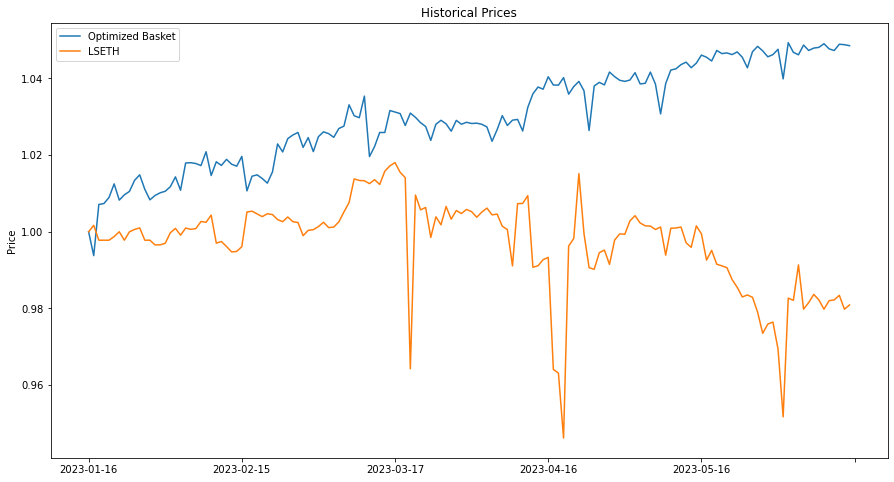

In [14]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(15, 8))

# Set price data to start at 1
normalized_optimized_basket = merged_df['Optimized Basket'] / merged_df['Optimized Basket'].iloc[0] 
normalized_lseth = merged_df['liquid-staked-eth-index'] / merged_df['liquid-staked-eth-index'].iloc[0] 

# Plot normalized price data
ax.plot(merged_df.index, normalized_optimized_basket, label='Optimized Basket')
ax.plot(merged_df.index, normalized_lseth, label='LSETH')
ax.set_ylabel('Price')
ax.set_title('Historical Prices')
ax.legend()

# Set tick frequency to show dates every 30 days
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))

plt.show()


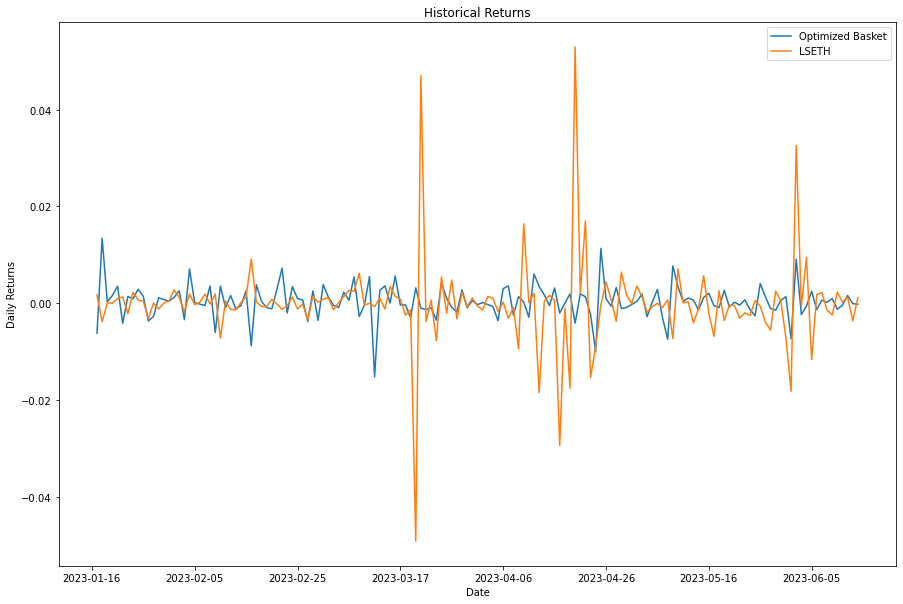

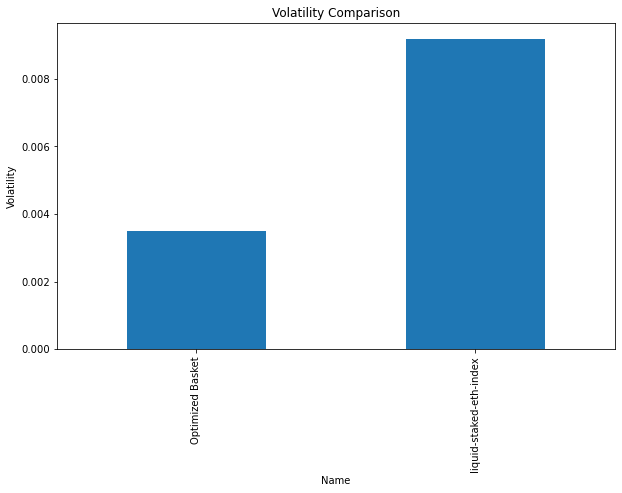

In [15]:
# Calculate daily returns
returns = merged_df[['Optimized Basket','liquid-staked-eth-index',]].pct_change()

# Calculate volatility (standard deviation of returns)
volatility = returns.std()

# Plotting the returns
plt.figure(figsize=(15, 10))
returns.plot(ax=plt.gca())
plt.ylabel('Daily Returns')
plt.title('Historical Returns')
plt.legend(['Optimized Basket', 'LSETH'])
plt.show()

# Plotting the volatility
plt.figure(figsize=(10, 6))
volatility.plot(kind='bar')
plt.ylabel('Volatility')
plt.title('Volatility Comparison')
plt.show()



We can see that the Optimized Basket generated better returns and lower volatilty. The optimized basket can still provide some diversification and mitigate underlying protocol risk compared to holding individual tokens.